## Analise Mensal Sem Anomalias 

✅ Sucesso! Os dados foram carregados em 'df_churn_mensal'.
------------------------------
   periodo  clientes_no_inicio_do_mes  total_churn_no_mes  \
0  2015-01                       4314                  78   
1  2015-02                       4338                  64   
2  2015-03                       4372                 100   
3  2015-04                       4374                  83   
4  2015-05                       4385                  63   
5  2015-06                       4429                 108   
6  2015-07                       4427                  62   
7  2015-08                       4576                  53   
8  2015-09                       4611                 114   
9  2015-10                       4588                  85   

   churn_rate_percentual   status_saude  
0                   1.81         ALERTA  
1                   1.48       SAUDÁVEL  
2                   2.29  CRÍTICO (>2%)  
3                   1.90         ALERTA  
4                   1.44    

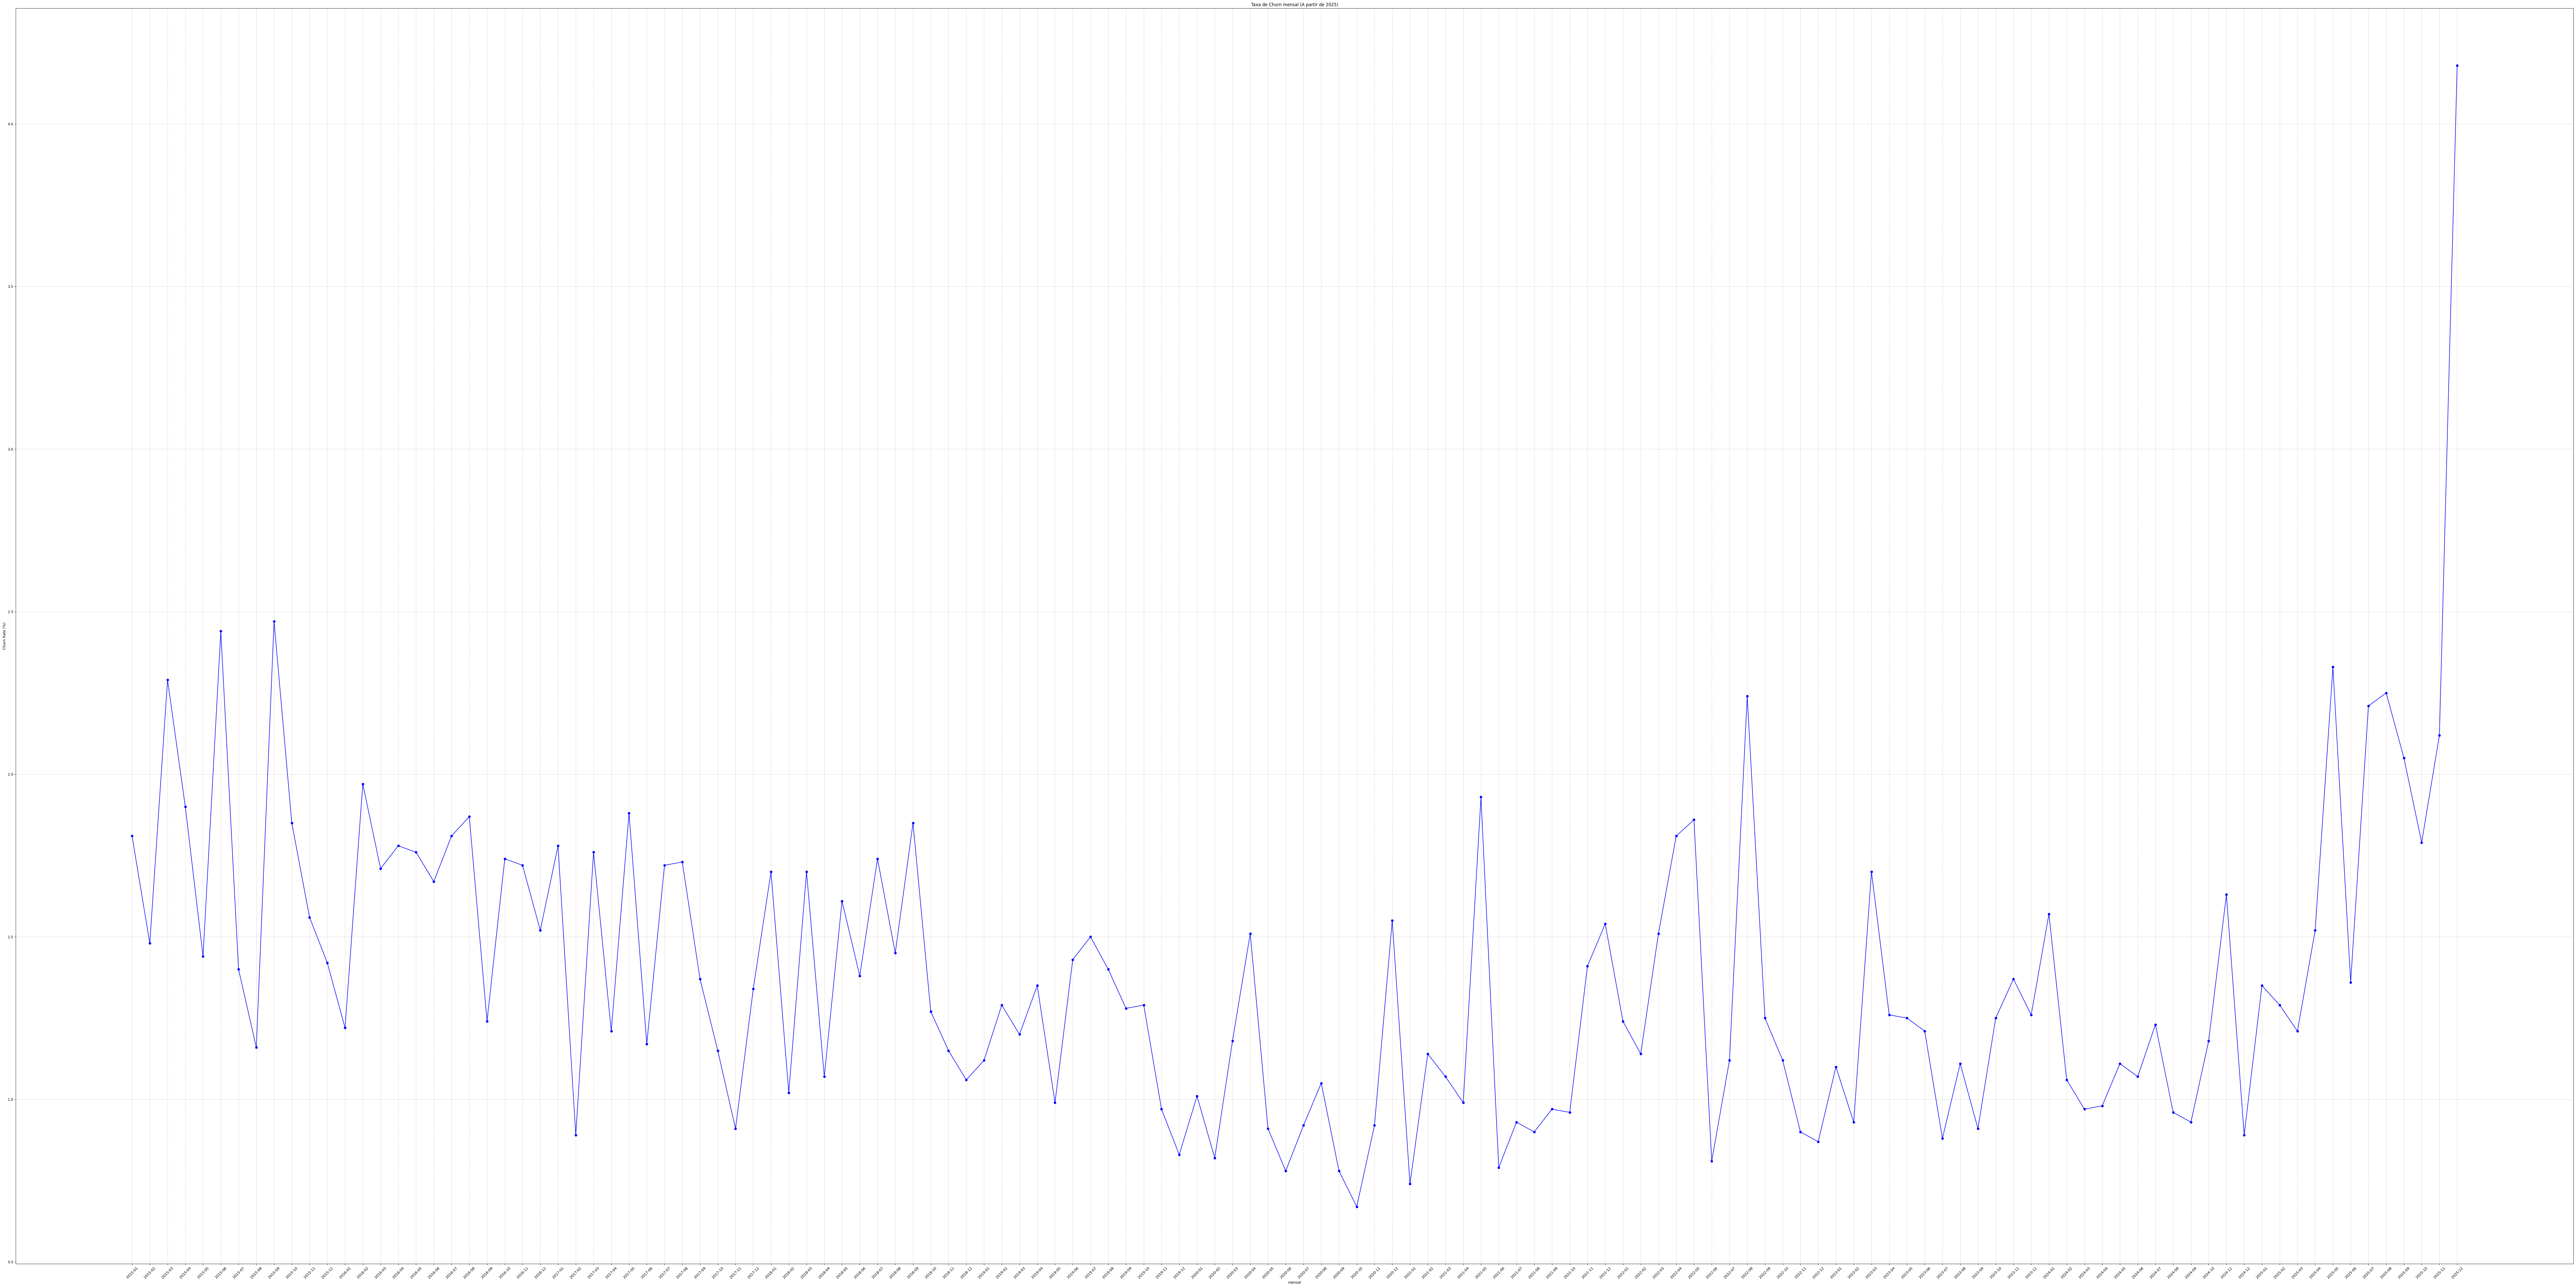

In [9]:
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt

# 1. Carregar variáveis de ambiente
load_dotenv()

# 2. Configuração das credenciais com tratamento de caracteres especiais
user     = os.getenv("PROD_POSTGRES_USERNAME")
password = urllib.parse.quote_plus(os.getenv("PROD_POSTGRES_PASSWORD"))
host     = os.getenv("PROD_POSTGRES_HOST")
database = os.getenv("PROD_POSTGRES_DATABASE")
port     = os.getenv("POST_PORT", "5432")

conn_url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_url)

# 3. Definição da Query SQL de Churn Semestral (Início em 2006)
sql_query = """
WITH base_contratos AS (
    SELECT DISTINCT
        c.nr_central_sigma,
        ccc.codigo_contrato,
        ccc.data_pedido AS data_inicio,
        ccc.data_rescisao,
        (
            SELECT mcc.situacao
            FROM movimento_contratos_cli mcc
            WHERE mcc.codigo_contrato = ccc.codigo_contrato
              AND mcc.situacao <> 7
            ORDER BY mcc.data_conclusao DESC
            LIMIT 1
        ) AS situacao_movimento
    FROM clientes c
    INNER JOIN cab_contratos_cli ccc 
        ON ccc.codigo_cliente = c.codigo_cliente
),

clientes_com_contrato_ativo AS (
    SELECT DISTINCT nr_central_sigma
    FROM base_contratos
    WHERE data_rescisao IS NULL
),

churn_por_cliente AS (
    SELECT
        bc.nr_central_sigma,
        MAX(bc.data_rescisao) AS data_churn
    FROM base_contratos bc
    WHERE bc.data_rescisao IS NOT NULL
      AND bc.nr_central_sigma NOT IN (
            SELECT nr_central_sigma FROM clientes_com_contrato_ativo
      )
    GROUP BY bc.nr_central_sigma
),

-- 📅 Calendário mensal fixo de 2015 a 2025
calendario_meses AS (
    SELECT generate_series(
        DATE '2015-01-01',
        DATE '2025-12-01',
        INTERVAL '1 month'
    )::date AS mes
),

churn_mensal AS (
    SELECT
        DATE_TRUNC('month', ch.data_churn) AS mes_churn,
        COUNT(DISTINCT ch.nr_central_sigma) AS clientes_churn
    FROM churn_por_cliente ch
    WHERE ch.data_churn BETWEEN '2015-01-01' AND '2025-12-31'
    GROUP BY 1
),

clientes_ativos_inicio_mes AS (
    SELECT
        cm.mes,
        COUNT(DISTINCT bc.nr_central_sigma) AS total_clientes_inicio
    FROM calendario_meses cm
    LEFT JOIN base_contratos bc
        ON bc.data_inicio < cm.mes
       AND (bc.data_rescisao IS NULL OR bc.data_rescisao >= cm.mes)
    GROUP BY cm.mes
)

SELECT
    TO_CHAR(cam.mes, 'YYYY-MM') AS periodo,
    cam.total_clientes_inicio AS clientes_no_inicio_do_mes,
    COALESCE(cm.clientes_churn, 0) AS total_churn_no_mes,

    ROUND(
        (COALESCE(cm.clientes_churn,0)::numeric 
        / NULLIF(cam.total_clientes_inicio,0)::numeric) * 100
    ,2) AS churn_rate_percentual,

    CASE 
        WHEN (COALESCE(cm.clientes_churn,0)::numeric / NULLIF(cam.total_clientes_inicio,0)) * 100 > 2.0 THEN 'CRÍTICO (>2%)'
        WHEN (COALESCE(cm.clientes_churn,0)::numeric / NULLIF(cam.total_clientes_inicio,0)) * 100 > 1.5 THEN 'ALERTA'
        ELSE 'SAUDÁVEL'
    END AS status_saude

FROM clientes_ativos_inicio_mes cam
LEFT JOIN churn_mensal cm 
       ON cam.mes = cm.mes_churn

WHERE cam.mes BETWEEN '2015-01-01' AND '2025-12-01'
ORDER BY cam.mes;

"""

# 4. Execução da consulta
try:
    with engine.connect() as conn:
        df_churn_mensal = pd.read_sql(text(sql_query), conn)

    print("✅ Sucesso! Os dados foram carregados em 'df_churn_mensal'.")
    print("-" * 30)
    print(df_churn_mensal.head(10)) # Exibe os primeiros 10 semestres 
    print("-" * 30)

    # 5. Visualização Básica
    plt.figure(figsize=(100, 50))
    plt.plot(df_churn_mensal['periodo'], df_churn_mensal['churn_rate_percentual'], marker='o', linestyle='-', color='b')
    plt.title('Taxa de Churn mensal (A partir de 2025)')
    plt.xlabel('mensal')
    plt.ylabel('Churn Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Erro ao executar consulta: {e}")

In [11]:
import pandas as pd
import numpy as np


# Média e Mediana 
media_mensal = df_churn_mensal['churn_rate_percentual'].mean()
mediana_mensal = df_churn_mensal['churn_rate_percentual'].median()


# 2. Estatísticas de Dispersão (Volatilidade)
desvio_padrao = df_churn_mensal['churn_rate_percentual'].std()
cv = (desvio_padrao / media_mensal) * 100  # Coeficiente de Variação
amplitude = df_churn_mensal['churn_rate_percentual'].max() - df_churn_mensal['churn_rate_percentual'].min()

# 3. Identificação de Outliers (Z-Score)
# O Z-score diz quantos desvios padrão um ano está longe da média
df_churn_mensal['z_score'] = (df_churn_mensal['churn_rate_percentual'] - media_mensal) / desvio_padrao

# Exibindo os resultados formatados
print(f"--- Diagnóstico Estatístico do Churn ---")
print(f"Média Histórica: {media_mensal:.2f}%")
print(f"Mediana Histórica: {mediana_mensal:.2f}%")
print(f"Desvio Padrão (Sigma): {desvio_padrao:.2f}")
print(f"Amplitude (Max-Min): {amplitude:.2f}%")
print(f"Coeficiente de Variação: {cv:.2f}%")
print("-" * 40)

# Filtrando anomalias (Z-Score > 1.5 ou < -1.5)
anomalias = df_churn_mensal[df_churn_mensal['z_score'].abs() > 1.5]
print("Anos com comportamento fora do padrão (Anomalias):")
print(anomalias[['periodo', 'churn_rate_percentual', 'z_score']])

--- Diagnóstico Estatístico do Churn ---
Média Histórica: 1.38%
Mediana Histórica: 1.27%
Desvio Padrão (Sigma): 0.47
Amplitude (Max-Min): 3.51%
Coeficiente de Variação: 34.22%
----------------------------------------
Anos com comportamento fora do padrão (Anomalias):
     periodo  churn_rate_percentual   z_score
2    2015-03                   2.29  1.915333
5    2015-06                   2.44  2.232208
8    2015-09                   2.47  2.295583
69   2020-10                   0.67 -1.506916
91   2022-08                   2.24  1.809708
124  2025-05                   2.33  1.999833
126  2025-07                   2.21  1.746333
127  2025-08                   2.25  1.830833
130  2025-11                   2.12  1.556208
131  2025-12                   4.18  5.907956


# 📉 Diagnóstico Estatístico: Churn Mensal

## 1. Comportamento Central e Volatilidade
Ao analisarmos o churn mensalmente, observamos uma sensibilidade muito maior a eventos pontuais em comparação à visão trimestral.

* **Média vs. Mediana:** A relação entre ambas indica se temos meses muito atípicos puxando o resultado. Se a média estiver muito acima da mediana, temos picos de cancelamento isolados que precisam de atenção.
* **Coeficiente de Variação (CV):** No gráfico mensal, a volatilidade parece alta. Se o seu **CV for superior a 20%**, significa que o comportamento dos clientes é instável e difícil de prever mês a mês.
* **Amplitude:** Revela a distância entre o mês de maior sucesso e o mês de maior crise.

---

## 2. Detecção de Outliers e Anomalias (Z-Score)
O **Z-Score** aplicado com o corte de **1.5** identifica os meses que estão estatisticamente "fora da curva".

| Faixa de Z-Score | Classificação | O que significa? |
| :--- | :--- | :--- |
| **|Z| > 1.5** | **Anomalia** | Meses com picos de cancelamento ou retenção fora do comum. |
| **0 a 1.5** | **Normalidade** | Oscilações naturais do mercado e sazonalidade. |

---

## 3. Análise do Cenário Atual (2025)
O gráfico mensal confirma uma tendência alarmante:
1.  **Explosão Final:** O último ponto do gráfico mensal mostra um salto quase vertical, atingindo o ponto mais alto de toda a série histórica.
2.  **Diagnóstico:** Este ponto terá, com certeza, o **maior Z-Score da sua tabela**. Isso caracteriza uma quebra estrutural no modelo de retenção que começou a se acelerar no final de 2024.

---

## 4. Próximos Passos Recomendados
* **Investigação de Causa Raiz:** Analisar o que ocorreu especificamente no último mês (reajuste de preço, falha técnica sistêmica ou ação agressiva de concorrente).
* **Suavização:** Como o gráfico mensal tem muito ruído, recomenda-se aplicar uma **Média Móvel de 3 meses** para identificar se a tendência de alta vai persistir.